# Interpretability Tests and Experiments

Going to do some prelim tests to show case mech interp techniques, mathematical unpinnings of said techniques and how it applies to the larger project.

This notebook serves as the proof-of-concept for the "Researcher Layer" of Clear-box AI web app. 
It validates the mathematical operations required for:
1. **Signal Extraction:** Capturing hidden states and attentions.
2. **Logit Attribution:** Understanding next-token prediction via the Logit Lens.
3. **Concept Visualization:** PCA projection of the residual stream.

**Model:** GPT-2 (Small)
**Goal:** Validate logic before porting to TypeScript/WebGPU.

In [2]:
# imports
import torch
import torch.nn.functional as F 
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device}")

Running on: cuda


### Engine Layer:

This corresponds to the `src/engine/ModelManager.ts`.
We use standard HuggingFace, but we explicitly request `output_hidden_states` and `output_attentions`.

In [4]:
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

# silly config thing that needs to be set for attention dumps, GPT2 defaults to using SDPA which don't preserve full attention matrices
# could be the same issue we are seeing in the js implementation!
model.config._attn_implementation = "eager" 

model.config.output_attentions=True # testing attention extraction prior to forward pass
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [6]:
def run_inference(prompt: str):
    """
    Run inference and capture internals.
    Equivalent to the Web Worker's `generate` func with full observability.
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(
            **inputs,
            output_hidden_states=True # ref for this on HF: https://huggingface.co/docs/transformers/v4.26.0/main_classes/output#transformers.modeling_outputs.BaseModelOutput.hidden_states
        )
    
    # hidden_states: Tuple of (layer_count + 1) tensors. Shape: [batch, seq, hidden]
    # attentions: Tuple of (layer_count) tensors. Shape: [batch, heads, seq, seq]
    # logits: Shape [batch, seq, vocab]
    if outputs.attentions:
        print(f"Attentions available, number of layers: {len(outputs.attentions)}")
    else:
        print("Attentions are still empty :(")

    return {
        "input_ids": inputs["input_ids"],
        "tokens": [tokenizer.decode([t]) for t in inputs["input_ids"][0]],
        "hidden_states": outputs.hidden_states,
        "attentions": outputs.attentions,
        "logits": outputs.logits
    }

In [7]:
# quick test run of inference func
prompt = "The Eiffel Tower is located in the city of"
data = run_inference(prompt)
print(f"Prompt tokens: {data['tokens']}")
print(f"Total layers captured: {len(data['hidden_states'])}") # should be 13 => Embed + 12 blocks

Attentions available, number of layers: 12
Prompt tokens: ['The', ' E', 'iff', 'el', ' Tower', ' is', ' located', ' in', ' the', ' city', ' of']
Total layers captured: 13


## Logit Attribution

This technique applies the Unembedding Matrix ($W_U$) to the hidden state of *intermediate* layers. It answers: "If we stopped the model at Layer $L$, what token would it predict?"

Mathematical Logic: $ Logits_L = h_L \cdot W_U^T $

This validates the logic for `src/vis/LogitDistribution.tsx`.

In [8]:
def logit_lens(hidden_states, model, tokenizer, top_k=5):
    """
    Apply language model head to every layer's hidden state.
    """
    unembed_matrix = model.lm_head.weight # shape: [vocab, hidden]
    # print(f"Vocab: {unembed_matrix[0]}\nHidden: {unembed_matrix[1]}")
    layer_preds = []

    for layer_idx, hidden in enumerate(hidden_states):
        # the hidden shape = [1, seq_len, 768]
        # only interested in the prediction at the last token pos
        last_hidden_token = hidden[0, -1, :] # shape: [768]

        # Project to vocab space
        # In the standard GPT-2, LayerNorm(ln_f) is applied before the head.
        # The strict logit lens usually bypasses ln_f for raw stream analysis
        # but for prediction parity, we should ideally apply it at the final layer.
        # We'll do a direct projection for raw residual stream analysis.
        logits = torch.matmul(unembed_matrix, last_hidden_token)
        probs = F.softmax(logits, dim=-1)
        top_probs, top_idxs = torch.topk(probs, top_k)

        preds = []
        for rank, (prob, idx) in enumerate(zip(top_probs, top_idxs)):
            token = tokenizer.decode([idx.item()])
            preds.append(f"{token} ({prob:.2f})")
        layer_preds.append(preds)
    
    return layer_preds


In [9]:
# execute logit lens
predictions = logit_lens(data["hidden_states"], model, tokenizer)

print(f"Target completion expected: ' Paris'\n")
for i, preds in enumerate(predictions):
    layer_name = "Embed" if i == 0 else f"Layer {i-1}"
    print(f"{layer_name: <10} | Top 5 prediction: {','.join([preds[i] for i in range(5)])}")

Target completion expected: ' Paris'

Embed      | Top 5 prediction:  of (0.00),of (0.00),- (0.00),, (0.00), in (0.00)
Layer 0    | Top 5 prediction:  the (1.00), a (0.00), " (0.00), ' (0.00), an (0.00)
Layer 1    | Top 5 prediction:  the (1.00), a (0.00), " (0.00), an (0.00), ' (0.00)
Layer 2    | Top 5 prediction:  the (1.00), a (0.00), " (0.00), ' (0.00), an (0.00)
Layer 3    | Top 5 prediction:  the (1.00), a (0.00), " (0.00), ' (0.00), D (0.00)
Layer 4    | Top 5 prediction:  the (1.00), a (0.00),sp (0.00), G (0.00), D (0.00)
Layer 5    | Top 5 prediction:  the (1.00),, (0.00), G (0.00), D (0.00), B (0.00)
Layer 6    | Top 5 prediction:  the (1.00),, (0.00), G (0.00), D (0.00), B (0.00)
Layer 7    | Top 5 prediction:  the (1.00),, (0.00), D (0.00), G (0.00), M (0.00)
Layer 8    | Top 5 prediction:  the (1.00),, (0.00), D (0.00), a (0.00), T (0.00)
Layer 9    | Top 5 prediction:  the (1.00),, (0.00), D (0.00), New (0.00), a (0.00)
Layer 10   | Top 5 prediction:  the (1.00),, (0.00)

It's interesting to see how low the probability for the predicted token ' Paris' is for this prompt. How can we try to force the probability for this specifc token to be higher with our current prompt? 

Maybe just giving more "french" nouns? Let's try it:

In [10]:
prompt_2 = "The Eiffel Tower and croissants are located in the city of"
data_run_2 = run_inference(prompt_2)
print(f"Prompt tokens: {data_run_2['tokens']}")

prompt_3 = "The Eiffel Tower and croissants and louis vuitton are located in the city of"
data_run_3 = run_inference(prompt_3)
print(f"Prompt tokens: {data_run_3['tokens']}")

prompt_4 = "The Eiffel Tower, croissants, and louis vuitton are located in the city of"
data_run_4 = run_inference(prompt_4)
print(f"Prompt tokens: {data_run_4['tokens']}")

Attentions available, number of layers: 12
Prompt tokens: ['The', ' E', 'iff', 'el', ' Tower', ' and', ' cro', 'iss', 'ants', ' are', ' located', ' in', ' the', ' city', ' of']
Attentions available, number of layers: 12
Prompt tokens: ['The', ' E', 'iff', 'el', ' Tower', ' and', ' cro', 'iss', 'ants', ' and', ' lou', 'is', ' v', 'u', 'itton', ' are', ' located', ' in', ' the', ' city', ' of']
Attentions available, number of layers: 12
Prompt tokens: ['The', ' E', 'iff', 'el', ' Tower', ',', ' cro', 'iss', 'ants', ',', ' and', ' lou', 'is', ' v', 'u', 'itton', ' are', ' located', ' in', ' the', ' city', ' of']


In [11]:
# execute context influence
predictions_2 = logit_lens(data_run_2["hidden_states"], model, tokenizer)
predictions_3 = logit_lens(data_run_3["hidden_states"], model, tokenizer)
predictions_4 = logit_lens(data_run_4["hidden_states"], model, tokenizer)

print(f"Target completion expected: ' Paris'\n")

print(f"Original Prompt: {prompt} (0.06)")

print(f"\nPrompt 2: {prompt_2}")
for i, preds in enumerate(predictions_2):
    layer_name = "Embed" if i == 0 else f"Layer {i-1}"
    print(f"{layer_name: <10} | Top 5 prediction: {','.join([preds[i] for i in range(5)])}")

print(f"\nPrompt 3: {prompt_3}")
for i, preds in enumerate(predictions_3):
    layer_name = "Embed" if i == 0 else f"Layer {i-1}"
    print(f"{layer_name: <10} | Top 5 prediction: {','.join([preds[i] for i in range(5)])}")

print(f"\nPrompt 4: {prompt_4}")
for i, preds in enumerate(predictions_4):
    layer_name = "Embed" if i == 0 else f"Layer {i-1}"
    print(f"{layer_name: <10} | Top 5 prediction: {','.join([preds[i] for i in range(5)])}")

Target completion expected: ' Paris'

Original Prompt: The Eiffel Tower is located in the city of (0.06)

Prompt 2: The Eiffel Tower and croissants are located in the city of
Embed      | Top 5 prediction:  of (0.00),of (0.00),, (0.00),- (0.00), in (0.00)
Layer 0    | Top 5 prediction:  the (1.00), a (0.00), " (0.00),, (0.00), ' (0.00)
Layer 1    | Top 5 prediction:  the (1.00), a (0.00), " (0.00), an (0.00), ' (0.00)
Layer 2    | Top 5 prediction:  the (1.00), a (0.00), " (0.00), ' (0.00), an (0.00)
Layer 3    | Top 5 prediction:  the (1.00), a (0.00), " (0.00),, (0.00), D (0.00)
Layer 4    | Top 5 prediction:  the (1.00), a (0.00),sp (0.00), G (0.00), D (0.00)
Layer 5    | Top 5 prediction:  the (1.00),, (0.00), D (0.00), G (0.00), a (0.00)
Layer 6    | Top 5 prediction:  the (1.00),, (0.00), D (0.00), G (0.00), a (0.00)
Layer 7    | Top 5 prediction:  the (1.00),, (0.00), D (0.00), a (0.00), G (0.00)
Layer 8    | Top 5 prediction:  the (1.00),, (0.00), D (0.00), a (0.00), " (0.00)
L

## Attention Visualization

We extract the attention pattern $A^h$ for a specific head $h$ in layer $l$.

$$ A^h = \text{softmax}(\frac{QK^T}{\sqrt{d_k}}) $$

In [12]:
def plot_attention_head(attentions, tokens, layer_idx, head_idx):
    """
    Visualizes attention weights for a specific head.
    """
    # grab layer at idx
    layer_attn = attentions[layer_idx] # [batch, heads, seq, seq]

    # grab attn at idx
    head_attn = layer_attn[0, head_idx, :, :].cpu().numpy() # [seq, seq]

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        head_attn,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap="viridis",
        square=True,
        annot=False # hide raw prob values
    )
    plt.title(f"Attention: Layer {layer_idx}, Head {head_idx}")
    plt.xlabel("Key (Source Token)")
    plt.xlabel("Query (Destination Token)")
    plt.show()


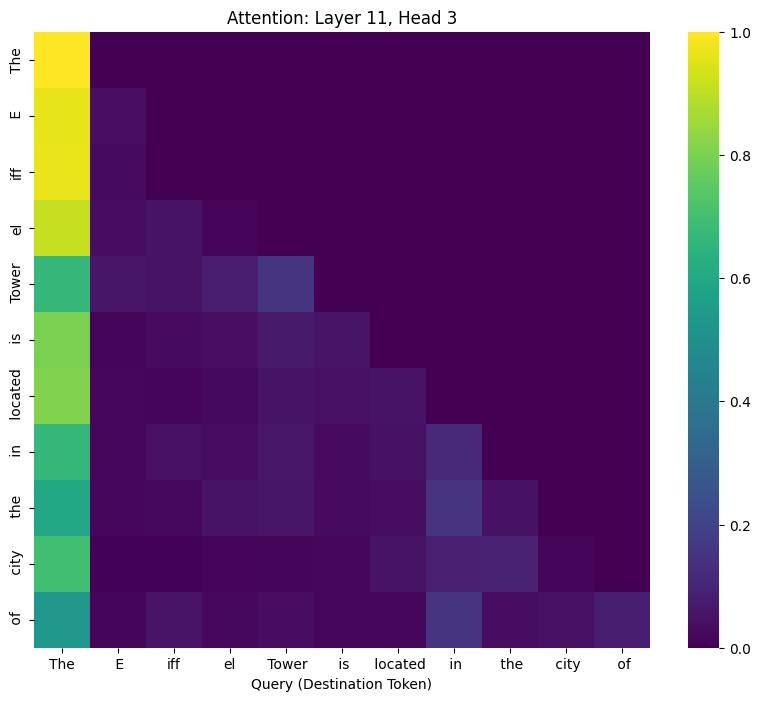

In [13]:
# testing a visual on layer 5, head 1
plot_attention_head(data['attentions'], data['tokens'], layer_idx=11, head_idx=3)

## Embedding Space (PCA Projection)

We take the trajectory of the residual stream in order to see how a single token's representation evolves layer by layer and project it to a 3D space


In [14]:
def plot_residual_traj(hidden_states, token_pos=1):
    """
    Plots path of a specified token position through the network layers.
    """

    # aggregate hidden state for the last token across all layers
    traj = torch.cat([h[0, token_pos, :].unsqueeze(0) for h in hidden_states], dim=0) # [num_layers, hidden_dim]

    # numpy conversion
    traj_np = traj.cpu().numpy()

    pca = PCA(n_components=2)
    projected = pca.fit_transform(traj_np)

    plt.figure(figsize=(10,6))
    plt.scatter(projected[:, 0], projected[:, 1], c=range(len(projected)), cmap='plasma', s=100)
    plt.plot(projected[:, 0], projected[:, 1], 'k--', alpha=0.3)

    # annotate plots
    for i, (x, y) in enumerate(projected):
        label = "Input" if i == 0 else f"L{i - 1}"
        plt.annotate(label, (x, y), xytext=(5, 5), textcoords='offset points')
    
    plt.title(f"Residual Stream Trajectory (PCA): Token Position {token_pos}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True, alpha=0.3)
    plt.colorbar(label="Layer Depth")
    plt.show()


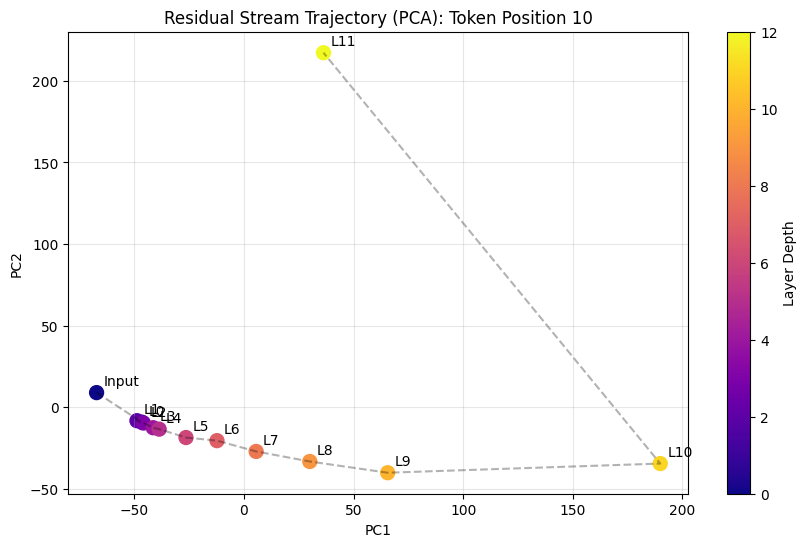

In [15]:
plot_residual_traj(data["hidden_states"], token_pos=10)

This is a pretty cool plot but it would be cooler to see all the tokens rendered in the same coordinate space.

should also make it a 3D plot. 

## Embedding Space (PCA) ... but 3D this time

We first need to create a unified coordinate space where all token representation can be compared. If we fit PCA separately for each token, their positions wouldn't be comparable (different basis vectors). By combining all tokens x all layers into one matrix, PCA finds teh directions of maximum variance across the entire residual stream.

In [16]:
def extract_all_token_traj(hidden_states, tokens):
    """
    Extract reps for ALL tokens across ALL layers.

    Returns:
        Representations: List of dicts, each containing:
            - 'vector': [768] tensor
            - 'token_idx': int (0 to seq_len - 1)
            - 'layer_idx': int (0 to 12)
            - 'token_text': str
    """
    seq_len = len(tokens)
    num_layers = len(hidden_states)

    representations = []
    for layer_idx in range(num_layers):
        hidden = hidden_states[layer_idx] # [1, seq_len, 768]
        for token_idx in range(seq_len):
            vector = hidden[0, token_idx, :] # [768]

            # we are adding metadata here to make it easier to plot...tensor object would be rough
            representations.append({
                'vector': vector,
                'token_idx': token_idx,
                'layer_idx': layer_idx,
                'token_text': tokens[token_idx]
            })
    
    return representations


Now we do the PCA transformations... The residual stream lives in 768 dimensions. PCA finds the 3 orthogonal directions that capture the most variance. These directions often correspond to:
- PC1: High-level semantic content (nouns vs verbs, concrete vs abstract)
- PC2: Positional information (begining vs end of seq)
- PC3: Syntactic role (subject vs object)

NOTE: we should check `explained_variance_ratio_` => if its < 60%, the 3D projection is losing important structure.

In [17]:
def fit_pca_3d(representations):
    """
    Fit PCA on all token reps combined.

    Returns:
        pca_results: List of dicts with added 'pca_coords' key [3]
        pca_model: Fitted PCA object (for inspecting explained variance)
    """

    # stack vects to matrix
    vectors_matrix = torch.stack([r['vector'] for r in representations]) # [num_tokens * num_layers, 768] => [11 * 13, 768]
    vectors_np = vectors_matrix.cpu().numpy()

    # fit pca with 3 components
    pca = PCA(n_components=3)
    pca_coords = pca.fit_transform(vectors_np) # [11 * 13, 3]

    # we'll add the pca coords back to each rep to keep things in one dict
    pca_results = []
    for i, rep in enumerate(representations):
        pca_results.append({
            **rep,
            'pca_coords': pca_coords[i] # adding [x, y, z]
        })
    
    return pca_results, pca

In [18]:
# checking variance
# print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
# print(f"Total variance captured: {pca.explained_variance_ratio_.sum():.2f}")

In [ ]:
def prepare_plot_data(pca_results):
      """
      Restructure data for Plotly consumption.
      
      Returns:
          Dict with keys:
              - 'tokens': {token_idx: {'x': [], 'y': [], 'z': [], 'layers': [], 'text': str}}
      """
      # Group by token_idx
      tokens_data = {}

      for result in pca_results:
          token_idx = result['token_idx']

          if token_idx not in tokens_data:
              tokens_data[token_idx] = {
                  'x': [],
                  'y': [],
                  'z': [],
                  'layers': [],
                  'text': result['token_text']
              }

          # grab PCA coordinates
          x, y, z = result['pca_coords']

          tokens_data[token_idx]['x'].append(x)
          tokens_data[token_idx]['y'].append(y)
          tokens_data[token_idx]['z'].append(z)
          tokens_data[token_idx]['layers'].append(result['layer_idx'])

      return tokens_data

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "vscode"

def plot_3d_trajectories(tokens_data):
    """
    Create interactive 3D scatter plot with trajectories.
    """
    fig = go.Figure()

    colors = px.colors.qualitative.Plotly

    for token_idx, data in tokens_data.items():
        # Calculate marker sizes (layer 0 → small, layer 12 → large)
        marker_sizes = [4 + (layer * 1.5) for layer in data['layers']]

        # Hover text for each point
        hover_texts = [
            f"Token: {data['text']}<br>Layer: {layer}"
            for layer in data['layers']
        ]

        fig.add_trace(go.Scatter3d(
            x=data['x'],
            y=data['y'],
            z=data['z'],
            mode='lines+markers',
            name=data['text'],  
            line=dict(
                color=colors[token_idx % len(colors)],
                width=2
            ),
            marker=dict(
                size=marker_sizes,
                color=colors[token_idx % len(colors)],
                line=dict(color='white', width=0.5)  # Outline for visibility
            ),
            hovertext=hover_texts,
            hoverinfo='text'
        ))

    fig.update_layout(
        scene=dict(
            xaxis_title='PC1 (Primary Semantic Axis)',
            yaxis_title='PC2 (Secondary Variance)',
            zaxis_title='PC3 (Tertiary Variance)',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.3)  # Initial viewing angle
            )
        ),
        title='Residual Stream Trajectories: All Tokens Across Layers',
        showlegend=True,
        hovermode='closest'
    )

    return fig

In [ ]:
# executing the new plots
representations = extract_all_token_traj(data['hidden_states'], data['tokens'])
print(f"Extracted {len(representations)} total representations")

pca_results, pca_model = fit_pca_3d(representations)

print(f"\nPCA Explained Variance:")
for i, var in enumerate(pca_model.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.2%}")
print(f"  Total: {pca_model.explained_variance_ratio_.sum():.2%}")

plot_data = prepare_plot_data(pca_results)

fig = plot_3d_trajectories(plot_data)
fig.show()

Extracted 143 total representations

PCA Explained Variance:
  PC1: 97.91%
  PC2: 0.60%
  PC3: 0.56%
  Total: 99.07%


Interesting interpretability questions to consider:

  1. Do tokens cluster by semantic type?
  E.g., Do "Eiffel" and "Tower" stay close together through layers?
  2. Where do trajectories diverge?
  If two tokens start close (similar embeddings) but end far apart, which layer causes the split? This reveals where the model differentiates their roles.
  3. Do function words vs. content words behave differently?
  Compare trajectories for "the" vs. "Paris" — function words often stay in a tight cluster.
  4. What does PC1 represent?
  Load the PCA components (pca_model.components_[0]) and find which vocabulary tokens have the highest dot product with it. This reveals what semantic dimension PC1 captures.